In [12]:
from Izh_net import *
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import correlate
from scipy.fft import fft

# Running procedure
def run(net, flexor, extensor, T, Iapp):
    dt = T[1] - T[0]
    N = len(net)
    U = np.zeros((len(T), N))
    V = np.zeros((len(T), N))
    Cn_f = np.zeros(len(T))
    X_f = np.zeros(len(T))
    F_f = np.zeros(len(T))
    Cn_e = np.zeros(len(T))
    X_e = np.zeros(len(T))
    F_e = np.zeros(len(T))
    W = np.zeros(len(T))
    Q = np.zeros(len(T))
    for i, t in enumerate(T):
        U[i] = net.U_prev
        V[i] = net.V_prev
        Cn_f[i] = flexor.Cn_prev
        X_f[i] = flexor.x
        F_f[i] = flexor.F_prev
        Cn_e[i] = extensor.Cn_prev
        X_e[i] = extensor.x
        F_e[i] = extensor.F_prev
        Q[i] = Limb.q
        W[i] = Limb.w
        net.step(dt=dt, Iapp=Iapp(t))
        uf = net.output[1]
        ue = net.output[2]
        flexor.step(dt=dt, u=uf)
        extensor.step(dt=dt, u=ue)
    return U, V, Cn_f, X_f, F_f, Cn_e, X_e, F_e

In [51]:
def calc_T(T, signal):    
    mean = np.mean(signal)
    mean_idx = np.where(np.logical_and(signal[1:]>=mean, signal[:-1]<=mean))
    plt.scatter(T[mean_idx], signal[mean_idx], color='m')
    plt.axhline(mean)
    T = np.mean(np.diff(T[mean_idx]))
    return T

def calc_df(T, signal1, signal2):
    # Вычисление кросс-корреляции
    correlation = correlate(signal1, signal2, mode='full')
    period = calc_T(T, signal1)
    # Нахождение индекса максимальной корреляции
    lag = np.argmax(correlation) - (len(signal1) - 1)

    # Вычисление временной задержки
    time_delay = lag * (T[1] - T[0])

    # Вычисление разности фаз
    phase_difference = 2 * np.pi * 1/period * time_delay  # Умножаем на частоту сигнала
    return phase_difference

(1, 1, 3)
0 0 0
0.8907523575181894


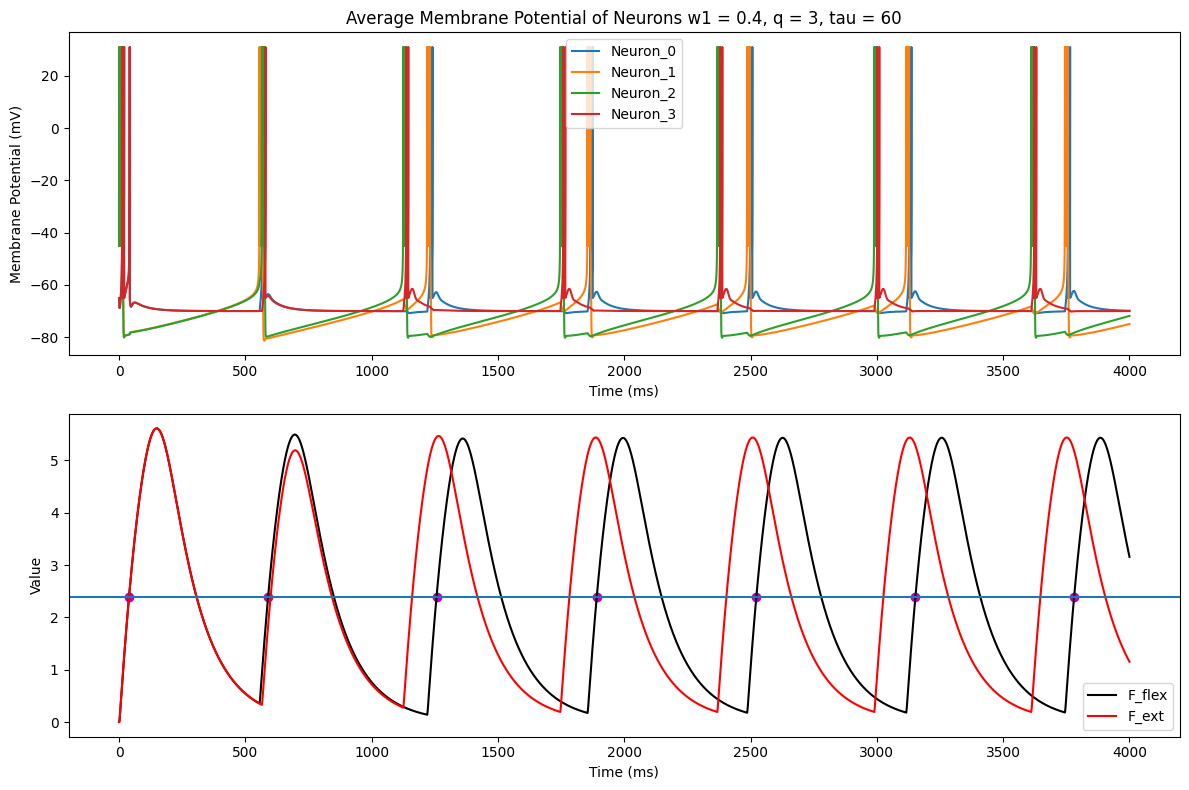

0 0 1
1.6652087885967581


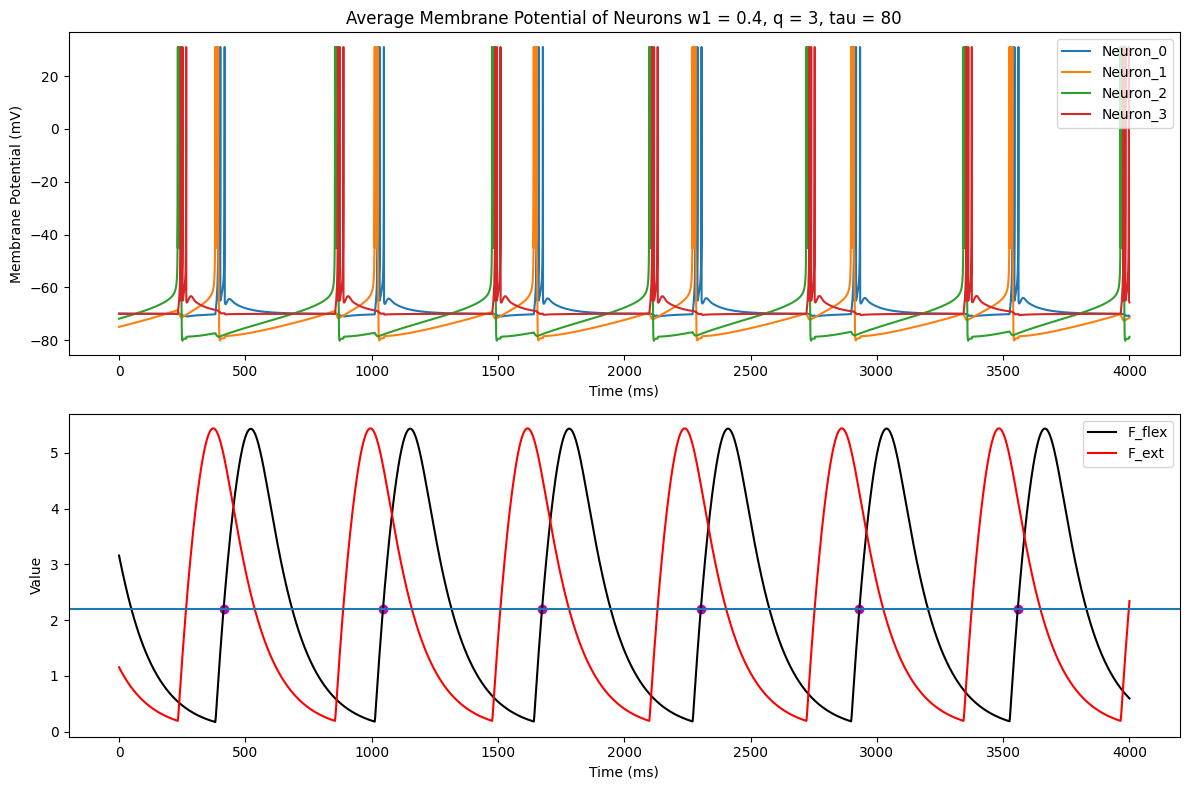

0 0 2
2.3634458830355984


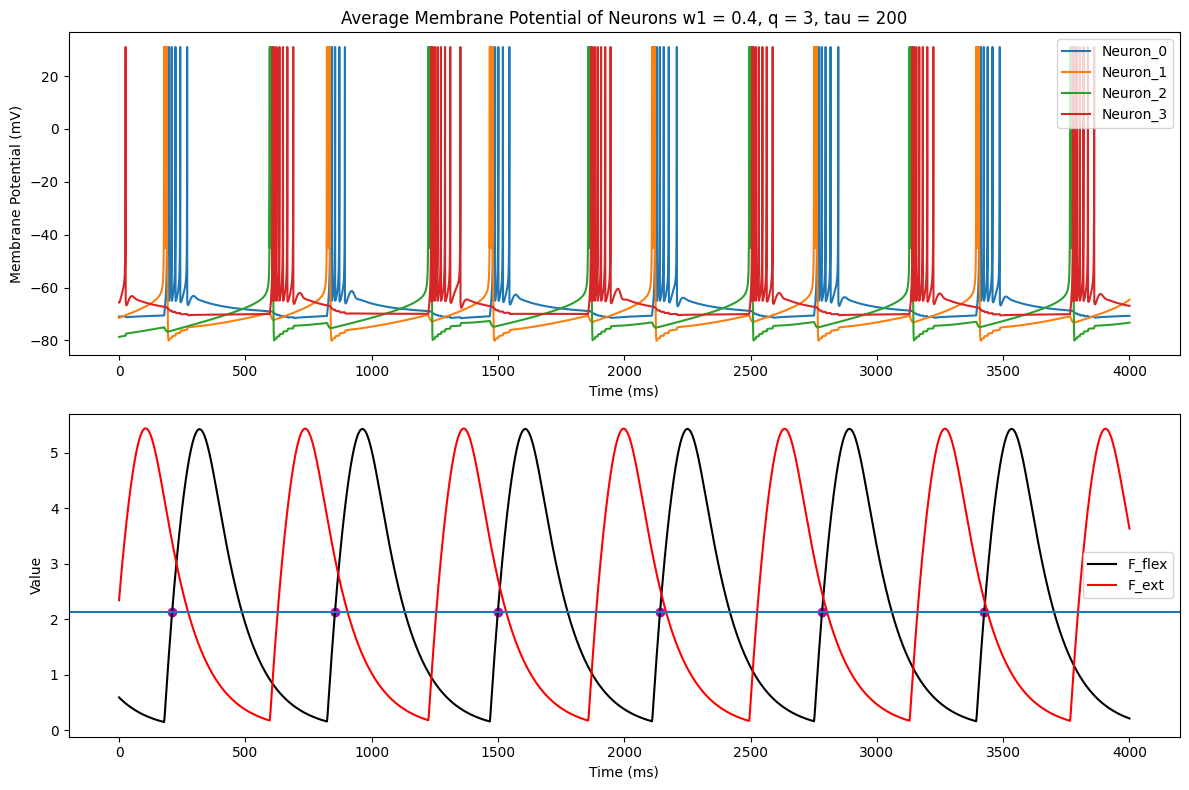

In [54]:
from scipy.signal import correlate
# Creating network
N = 4
net = Izhikevich_Network(N=N)
net.set_init_conditions()
a = 0.001
b = 0.46
c = -45
d = 2
N1 = izhikevich_neuron(preset=None, a=a, b=b, c=c, d=d)
N2 = izhikevich_neuron(preset=None, a=a, b=b, c=c, d=d)

A = a * np.ones(N) #+ 0.0001 * np.random.randn(N)  # Adding fixed noise to a
A[0] = 0.1; A[3] = 0.1
B = b * np.ones(N)
B[0] = 0.2; B[3] = 0.2
C = c * np.ones(N)
C[0] = -65; C[3] = -65
D = d * np.ones(N)
D[0] = 0.05; D[3] = 0.05
net.set_params(a=A, b=B, c=C, d=D)
# Limb settings
flexor = SimpleAdaptedMuscle(w=1)
extensor = SimpleAdaptedMuscle(w=1)
    
I = np.zeros(N)
I[1] = 0.1
I[-1] = 0
input = lambda t: I #+ 2 * np.random.randn(N)
T = np.linspace(0, 4000, 150000)   
dt = T[1]-T[0]

# Set the random seed for reproducibility
np.random.seed(2000)

# Number of simulations
num_simulations = 1

# Define the parameter sets for each Q
w1_values =  np.array([0.4])#[0.5, 0.6, 0.8, 0.9, 1.0]
q_values = np.array([3])#np.linspace(1, 10, 10)
tau_values = np.array([60, 80, 200])#[1, 5, 10, 20, 40, 60, 80, 100]

# Accumulate results
results = []
DF = np.zeros((len(w1_values), len(q_values), len(tau_values)))
print(DF.shape)
# Accumulate results
for II, w1 in enumerate(w1_values):
    for J, q in enumerate(q_values):
        for K, tau in enumerate(tau_values):
            print(II, J, K)
            net.set_weights(np.array([
                [0, w1*q, 0, -w1],
                [w1*q, 0, -w1, 0],
                [0, -w1, 0, w1*q],
                [-w1, 0, w1*q, 0]
            ]))
            net.set_synaptic_relax_constant(
                np.array(
                    [
                        [1, tau, 1, tau],
                        [tau, 1, tau, 1],
                        [1, tau, 1, tau],
                        [tau, 1, tau, 1]
                    ]
                )
            )
            U, V, Cn_f, X_f, F_f, Cn_e, X_e, F_e = run(net, flexor, extensor, T, input)
            # Visualization
            plt.figure(figsize=(12, 8))
        
            plt.subplot(211)
            for i in range(N):
                plt.plot(T, V[:, i], label=f"{net.names[i]}")
            plt.xlabel('Time (ms)')
            plt.ylabel('Membrane Potential (mV)')
            plt.title(f'Average Membrane Potential of Neurons w1 = {w1}, q = {q}, tau = {tau}')
            plt.legend()
        

        
            plt.subplot(2, 1, 2)
            plt.plot(T, F_f, label="F_flex", color='k')
            plt.plot(T, F_e, label="F_ext", color='r')
            DF[II, J, K] = calc_df(T, F_f, F_e)
            print(DF[II, J, K])
            plt.xlabel('Time (ms)')
            plt.ylabel('Value')
            plt.legend()

        
            plt.tight_layout()
        
            # Define the directory path
            #directory = './sys_exp_I_0.01/'
        
            # Create the directory if it does not exist
            #os.makedirs(directory, exist_ok=True)
        
            # Save the figure with the specified filename
            #filename = os.path.join(directory, f'w1={w1}_q={q}_tau={tau}.png')
            #plt.savefig(filename)
            plt.show()

In [53]:
np.pi/2

1.5707963267948966